In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import random
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import pandas as pd
from particle import *
data_dir = 'data_for_training'
img_size = (256, 256)
num_classes = 3
batch_size = 32
data_aug_fold = 4

data_paths = pathlib.Path(data_dir)

input_img_paths = list(data_paths.glob("*/raw/*"))

input_img_paths = sorted(input_img_paths, key=os.path.basename)

target_img_paths = list(data_paths.glob("*/label/*"))
target_img_paths = sorted(target_img_paths, key=os.path.basename)

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)
model = tf.keras.models.load_model("models/particle_segmentation_lp-2021-11-12.h5", custom_objects={"UpdatedMeanIoU": UpdatedMeanIoU})
model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=[UpdatedMeanIoU(num_classes=3)])

2021-11-12 17:14:24.699632: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-12 17:14:27.145790: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-12 17:14:27.199280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-11-12 17:14:27.201223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-11-12 17:14:27.203113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: 

In [2]:


val_samples = int(len(input_img_paths)//5)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

val_gen = lp_particles(batch_size, img_size, val_input_img_paths[:100], val_target_img_paths[:100])
val_preds = model.predict(val_gen)


2021-11-12 17:14:35.982374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 17:14:35.982914: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2021-11-12 17:14:37.620830: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-11-12 17:14:38.997726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-11-12 17:14:40.933405: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-12 17:14:41.973359: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


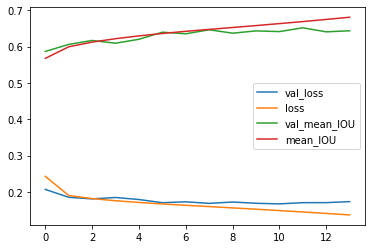

In [6]:
history = pd.read_csv('history.csv')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['loss'], label = 'loss')
plt.plot(history['val_updated_mean_io_u'], label='val_mean_IOU')
plt.plot(history['updated_mean_io_u'], label = 'mean_IOU')

plt.legend()
plt.savefig('figures/train_history.png')

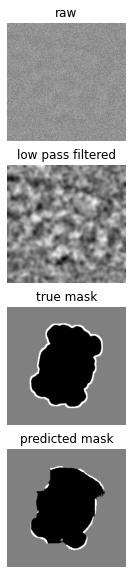

In [13]:

fig,ax = plt.subplots(4,1,figsize=(10,10))
pred_idx = 5
raw = np.load(val_input_img_paths[pred_idx])
true_mask = np.load(val_target_img_paths[pred_idx])
pred_mask = np.argmax(val_preds[pred_idx], axis=-1)
#pred_mask = np.expand_dims()
ax[0].imshow(raw, cmap='gray')
ax[0].set_title('raw')
ax[1].imshow(gaussian_filter(raw, sigma=5), cmap='gray')
ax[1].set_title('low pass filtered')
ax[2].imshow(true_mask, cmap='gray')
ax[2].set_title('true mask')
ax[3].imshow(pred_mask, cmap='gray')
ax[3].set_title('predicted mask')
[axi.set_axis_off() for axi in ax.ravel()]
fig.savefig('figures/predictions_in_dataset.png')

In [14]:
import mrcfile
test_idx = 0
test_dir = 'gpr158_3d/Extract/job005/goodmrc_1221'
test_paths = list(pathlib.Path(test_dir).glob('*.mrcs'))[:2]
for item in test_paths:
    with mrcfile.open(item) as mrc:
        for i in range(len(mrc.data)):
            np.save(f'tmp/{i+1}@@{item.name[:-1]}.npy', mrc.data[i])
test_paths = list(pathlib.Path('tmp').glob('*'))
test_gen = lp_inference_particles(4,img_size,input_img_paths=test_paths)
test_preds = model.predict(test_gen)
print(len(test_paths))

16


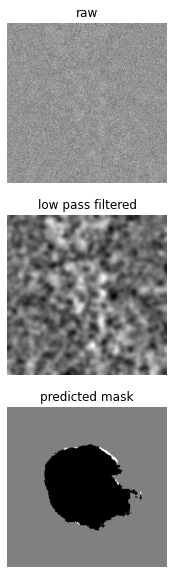

In [16]:

fig,ax = plt.subplots(3,1,figsize=(10,10))
pred_idx = 11
raw = np.load(test_paths[pred_idx])
pred_mask = np.argmax(test_preds[pred_idx], axis=-1)
ax[0].imshow(raw, cmap='gray')
ax[0].set_title('raw')
ax[1].imshow(gaussian_filter(raw, sigma=5), cmap='gray')
ax[1].set_title('low pass filtered')
ax[2].imshow(pred_mask, cmap='gray')
ax[2].set_title('predicted mask')
[axi.set_axis_off() for axi in ax.ravel()]
fig.savefig('figures/predictions_in_gpr158.png')